In [65]:
import pandas as pd

In [66]:
df = pd.read_csv("results.csv")
df

,n_nodes,n_edges,avg_degree,avg_clustering,n_sources,n_infected_nodes,n_iterations,percentage_infected,beta,threshold_infected,graph_type,neighbours,prob_reconnect
0,131,131,1.000000,0.000000,4,40,27,0.037108,0.128382,0.286480,watts_strogatz,2,0.233689
1,708,1416,2.000000,0.261384,34,440,7,0.049107,0.284080,0.498066,watts_strogatz,5,0.220991
2,332,332,1.000000,0.000000,8,151,26,0.026584,0.448967,0.440083,watts_strogatz,2,0.491708
3,284,283,0.996479,0.000000,6,97,14,0.023474,0.195024,0.287531,barabasi_albert,1,0.200873
4,154,154,1.000000,0.015152,2,88,51,0.013261,0.212788,0.562779,watts_strogatz,2,0.353269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9492,436632,46.000000,0.166991,178,9492,3,0.018821,0.377587,0.333076,watts_strogatz,92,0.398050
9996,9602,411037,42.807436,0.032103,326,9602,4,0.033967,0.237037,0.718213,barabasi_albert,43,0.321127
9997,9967,476112,47.768837,0.033437,138,9967,4,0.013872,0.363369,0.789226,barabasi_albert,48,0.421031
9998,9819,410634,41.820348,0.030987,369,9819,4,0.037611,0.188437,0.460572,barabasi_albert,42,0.019220


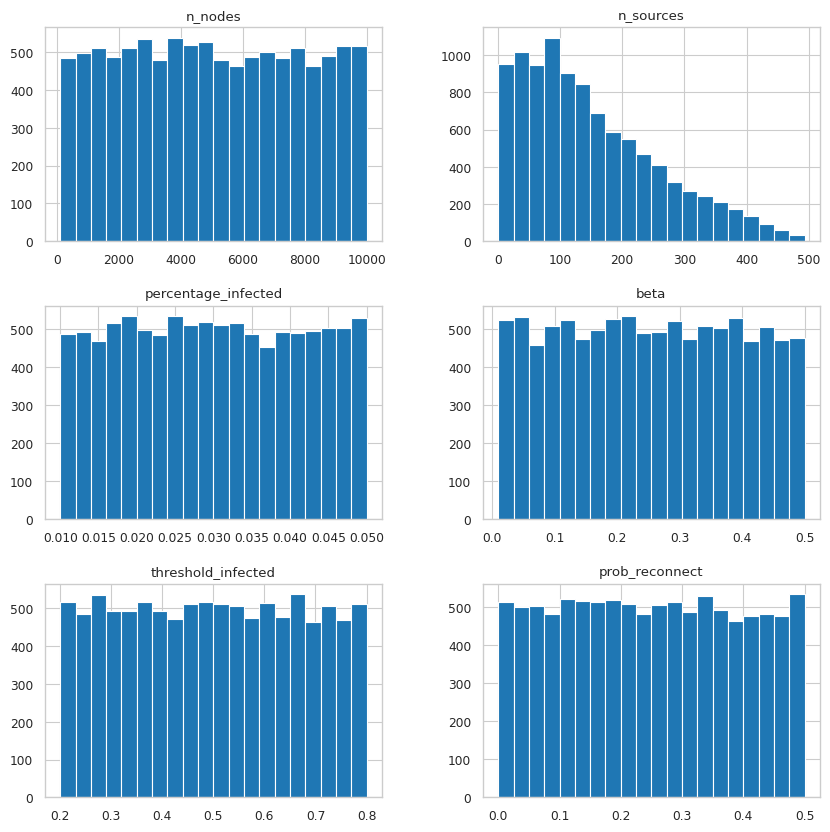

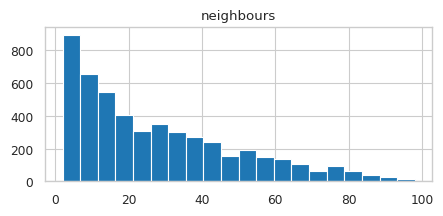

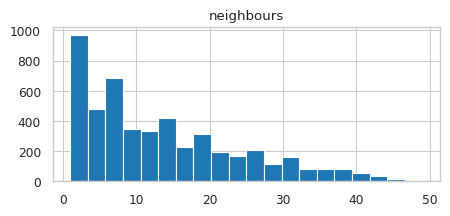

watts_strogatz     5016
barabasi_albert    4984
Name: graph_type, dtype: int64

In [67]:
# check the distributions of the parameters
import matplotlib.pyplot as plt

df[["n_nodes", "n_sources", "percentage_infected", "beta", "threshold_infected", "prob_reconnect"]].hist(figsize=(10, 10), bins=20)
plt.show()

df.loc[df["graph_type"] == "watts_strogatz",["graph_type", "neighbours"]].hist(figsize=(5, 2), bins=20)
plt.show()

df.loc[df["graph_type"] == "barabasi_albert",["graph_type", "neighbours"]].hist(figsize=(5, 2), bins=20)
plt.show()

# count the number of graphs of each type
df["graph_type"].value_counts()

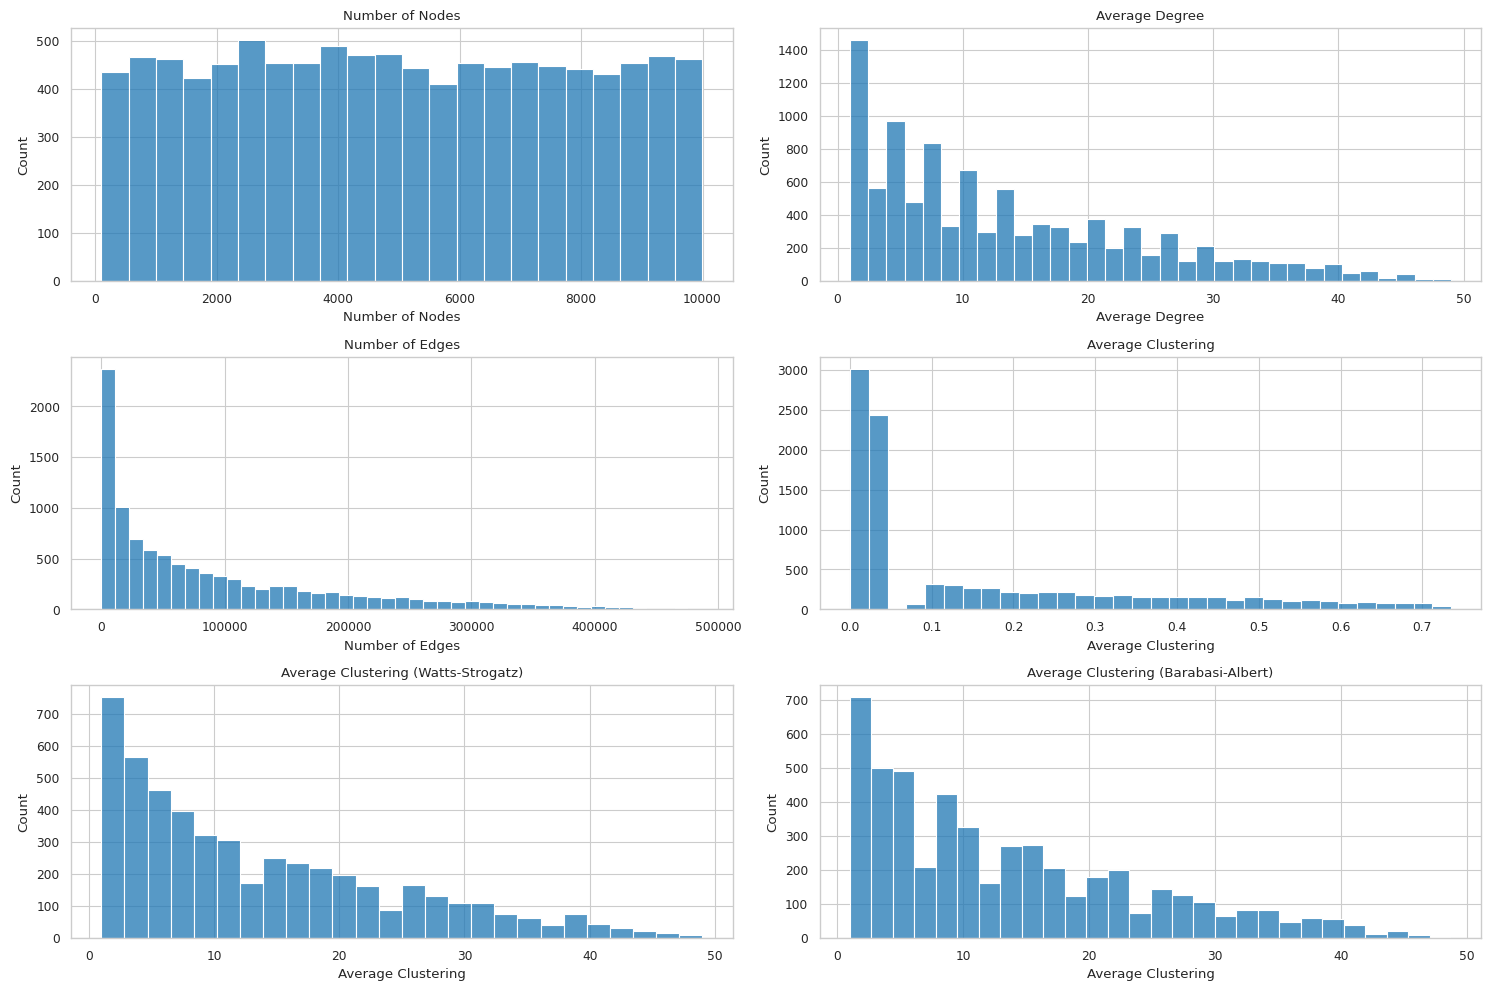

In [68]:
# visualize the graph metrics
# create a histogram for each metric
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

sns.histplot(data=df, x="n_nodes", ax=ax[0, 0])
sns.histplot(data=df, x="n_edges", ax=ax[1, 0])
sns.histplot(data=df, x="avg_degree", ax=ax[0, 1])
sns.histplot(data=df, x="avg_clustering", ax=ax[1, 1])
sns.histplot(data=df[df["graph_type"]=="watts_strogatz"], x="avg_degree", ax=ax[2, 0])
sns.histplot(data=df[df["graph_type"]=="barabasi_albert"], x="avg_degree", ax=ax[2, 1])

# add axis labels
ax[0, 0].set_xlabel("Number of Nodes")
ax[1, 0].set_xlabel("Number of Edges")
ax[0, 1].set_xlabel("Average Degree")
ax[1, 1].set_xlabel("Average Clustering")
ax[2, 0].set_xlabel("Average Clustering")
ax[2, 1].set_xlabel("Average Clustering")

# add title
ax[0, 0].set_title("Number of Nodes")
ax[1, 0].set_title("Number of Edges")
ax[0, 1].set_title("Average Degree")
ax[1, 1].set_title("Average Clustering")
ax[2, 0].set_title("Average Clustering (Watts-Strogatz)")
ax[2, 1].set_title("Average Clustering (Barabasi-Albert)")

plt.tight_layout()
plt.show()

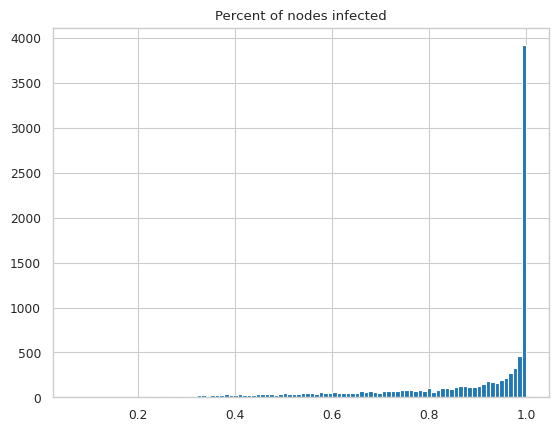

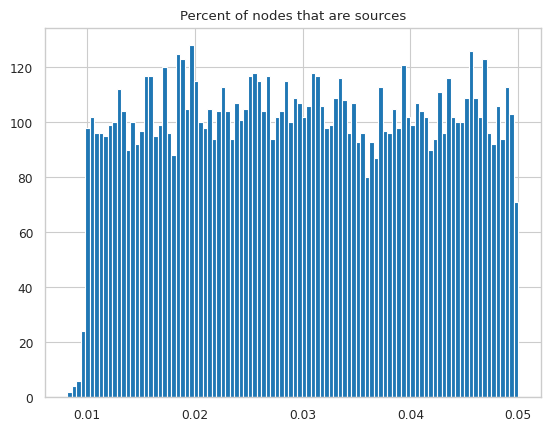

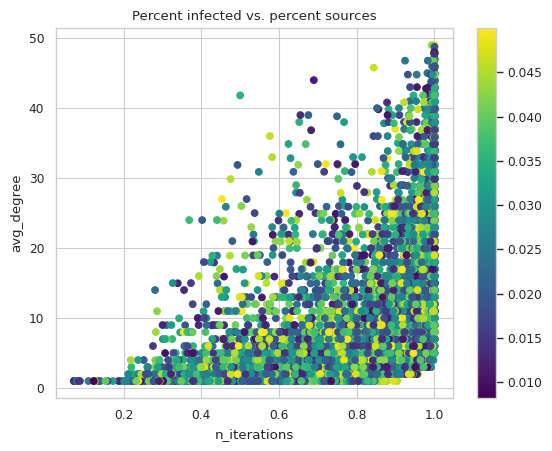

In [78]:
df["percent_infected"] = df["n_infected_nodes"] / df["n_nodes"]
df["percent_sources"] = df["n_sources"] / df["n_nodes"]

# plot the results
import matplotlib.pyplot as plt

plt.hist(df["percent_infected"], bins=100)
plt.title("Percent of nodes infected")
plt.show()

plt.hist(df["percent_sources"], bins=100)
plt.title("Percent of nodes that are sources")
plt.show()

df["graph_type_numeric"] = df["graph_type"].map({"watts_strogatz": 0, "barabasi_albert": 1}) 

# plot a scatter plot of percent infected vs. percent sources colored by number of iterations
plt.scatter(
    df["percent_infected"],
    df["avg_degree"],
    c=df["percent_sources"],
    cmap="viridis",
)
plt.colorbar()
plt.title("Percent infected vs. percent sources")
plt.xlabel("percent_infected")
plt.ylabel("avg_degree")
plt.show()

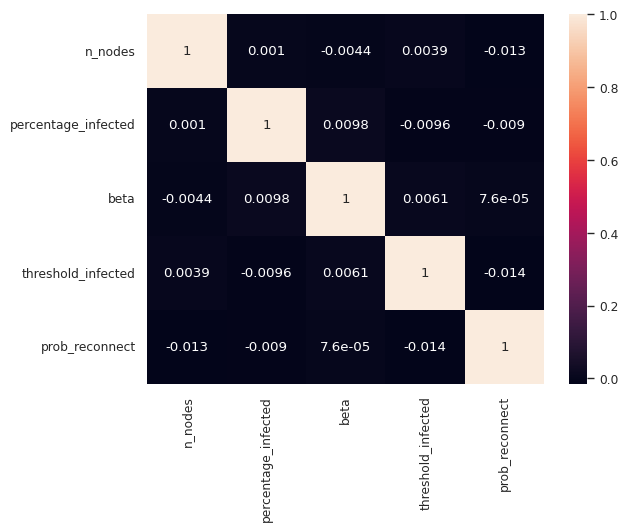

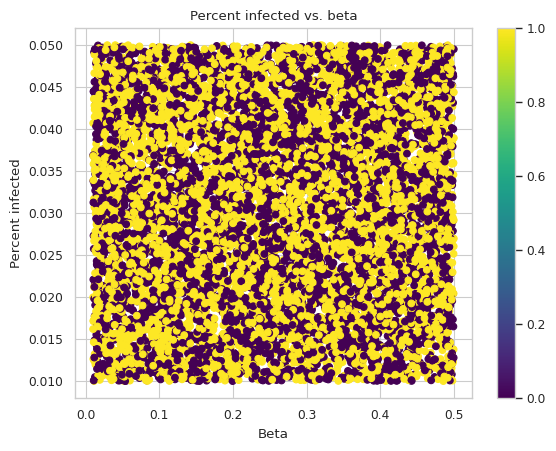

In [70]:
# check for correlation between parameters
import seaborn as sns

sns.heatmap(df[["n_nodes", "percentage_infected", "beta", "threshold_infected", "prob_reconnect"]].corr(), annot=True)
plt.show()

# create a scatter plot of percent infected vs. beta
plt.scatter(
    df["beta"],
    df["percentage_infected"],
    c=df["graph_type_numeric"],
    cmap="viridis",
)
plt.colorbar()
plt.title("Percent infected vs. beta")
plt.xlabel("Beta")
plt.ylabel("Percent infected")
plt.show()

In [3]:
# iterate over every data object in the data/training/synthetic/raw folder
import os
import pandas as pd
import torch
from pathlib import Path
from tqdm import tqdm
import glob

data_dir = Path("data/training/synthetic/raw")
data_files = os.listdir(data_dir)
data_files = glob.glob(f"{data_dir}/*.pt")

# create a list of dictionaries to store the data
metrics = []
settings = []

for data_file in tqdm(data_files):
    data = torch.load(data_file)
    metrics.append(data.metrics)
    settings.append(data.settings)
df_metrics = pd.DataFrame(metrics)
df_settings = pd.DataFrame(settings)
df_metrics.to_csv("metrics.csv")
df_settings.to_csv("settings.csv")

100%|██████████| 5000/5000 [00:53<00:00, 93.58it/s] 


In [21]:
df_settings

,graph_type,neighbours,prob_reconnect,beta,threshold_infected,iterations,percentage_initially_infected,currently_infected
0,barabasi_albert,41,0.016128,0.013595,0.282067,6,0.016464,1522
1,watts_strogatz,27,0.013661,0.011344,0.484574,17,0.029546,1962
2,watts_strogatz,82,0.049365,0.021831,0.422295,6,0.014055,1243
3,barabasi_albert,61,0.158710,0.022224,0.248727,4,0.038745,3339
4,barabasi_albert,2,0.241854,0.015571,0.497742,50,0.023492,756
...,...,...,...,...,...,...,...,...
995,barabasi_albert,4,0.194194,0.028636,0.362905,15,0.022305,924
996,watts_strogatz,70,0.115641,0.043119,0.446165,4,0.042622,3062
997,watts_strogatz,47,0.236890,0.020015,0.497907,7,0.034487,2557
998,barabasi_albert,57,0.043589,0.035291,0.357930,4,0.038097,2411


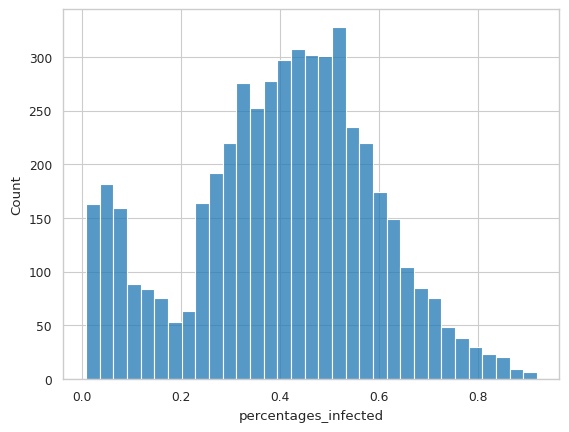

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_settings = pd.read_csv("settings.csv")
df_metrics = pd.read_csv("metrics.csv")
# join the two dataframes on the index
# remove column "Unnamed: 0" from df_metrics
df_metrics = df_metrics.drop(columns=["Unnamed: 0"])
df_metrics = df_metrics.join(df_settings)
df_metrics["percentages_infected"] = df_metrics["currently_infected"] / df_metrics["n_nodes"]

sns.histplot(data=df_metrics, x="percentages_infected")
plt.show()

In [3]:
df_metrics

,average_clustering_coefficient,average_degree,n_nodes,n_edges,avg_degree_centrality,Unnamed: 0,graph_type,neighbours,prob_reconnect,beta,threshold_infected,iterations,percentage_initially_infected,currently_infected,percentages_infected
0,0.077780,80.726515,2640,106559,0.030590,0,barabasi_albert,41,0.016128,0.058837,0.282067,4,0.016464,2472,0.936364
1,0.658433,26.000000,3634,47242,0.007157,1,watts_strogatz,27,0.013661,0.050110,0.484574,7,0.029546,2666,0.733627
2,0.544952,82.000000,1687,69167,0.048636,2,watts_strogatz,82,0.049365,0.090774,0.422295,4,0.014055,1624,0.962656
3,0.076558,120.182218,4094,246013,0.029363,3,barabasi_albert,61,0.158710,0.092298,0.248727,3,0.038745,4004,0.978017
4,0.015874,3.996113,2058,4112,0.001943,4,barabasi_albert,2,0.241854,0.066500,0.497742,16,0.023492,1142,0.554908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.021208,7.984229,2029,8100,0.003937,995,barabasi_albert,4,0.194194,0.117160,0.362905,6,0.022305,1235,0.608674
996,0.339236,70.000000,3531,123585,0.019830,996,watts_strogatz,70,0.115641,0.173319,0.446165,4,0.042622,3531,1.000000
997,0.114592,46.000000,3769,86687,0.012208,997,watts_strogatz,47,0.236890,0.083731,0.497907,5,0.034487,3758,0.997081
998,0.099698,111.487239,2586,144153,0.043129,998,barabasi_albert,57,0.043589,0.142964,0.357930,3,0.038097,2581,0.998067


<Axes: xlabel='avg_degree_centrality', ylabel='percentages_infected'>

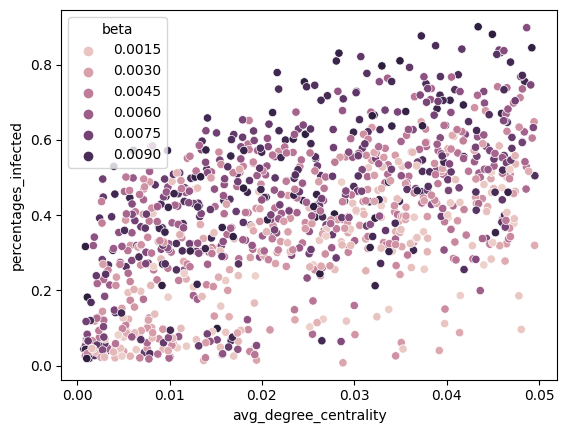

In [27]:
# plot the relationship between iterations and percentage infected
# set x-axis range to 0-10

sns.scatterplot(data=df_metrics, x="avg_degree_centrality", y="percentages_infected", hue="beta")

In [4]:
# show the the top 10 highest percentage infected examples
df_metrics[df_metrics["percentages_infected"] == 1].sort_values(by="avg_degree_centrality", ascending=True).head(20)

,average_clustering_coefficient,average_degree,n_nodes,n_edges,avg_degree_centrality,Unnamed: 0,graph_type,neighbours,prob_reconnect,beta,threshold_infected,iterations,percentage_initially_infected,currently_infected,percentages_infected
555,0.042700,61.582899,4608,141887,0.013367,555,barabasi_albert,31,0.123764,0.199710,0.368789,4,0.016983,4608,1.0
713,0.314808,38.000000,2728,51832,0.013935,713,watts_strogatz,38,0.122349,0.192661,0.477315,4,0.044753,2728,1.0
173,0.282430,52.000000,3705,96330,0.014039,173,watts_strogatz,52,0.139349,0.167465,0.381859,4,0.038408,3705,1.0
204,0.676159,64.000000,3776,120832,0.016954,204,watts_strogatz,64,0.014387,0.160837,0.474147,4,0.047299,3776,1.0
988,0.053472,87.204765,4869,212300,0.017914,988,barabasi_albert,44,0.141238,0.142913,0.408084,4,0.017384,4869,1.0
497,0.054781,63.417354,3515,111456,0.018047,497,barabasi_albert,32,0.055136,0.189232,0.421736,4,0.014425,3515,1.0
939,0.057506,73.261597,3708,135827,0.019763,939,barabasi_albert,37,0.021760,0.163785,0.365674,4,0.037545,3708,1.0
996,0.339236,70.000000,3531,123585,0.019830,996,watts_strogatz,70,0.115641,0.173319,0.446165,4,0.042622,3531,1.0
970,0.057957,63.357188,3186,100928,0.019892,970,barabasi_albert,32,0.218568,0.185943,0.317651,4,0.029443,3186,1.0
240,0.161556,62.000000,3060,94860,0.020268,240,watts_strogatz,62,0.205765,0.172654,0.282970,4,0.018856,3060,1.0


In [ ]:
import torch_geometric as pyg

# show the the top 10 highest percentage infected examples
top_10_infected = df_metrics.sort_values(by="percentages_infected", ascending=False)

# plot the graph with the highest percentage infected
import networkx as nx

# get the graph with the highest percentage infected
highest_infected = top_10_infected.iloc[0]
# load the graph
data = torch.load(Path("data/training/synthetic/raw") / f"{highest_infected['Unnamed: 0']}.pt")
graph = pyg.utils.convert.to_networkx(data).to_undirected()
# plot the graph
plt.figure(figsize=(100, 100))	
nx.draw(graph)

Index(['Unnamed: 0', 'average_clustering_coefficient', 'average_degree',
       'n_nodes', 'n_edges', 'avg_degree_centrality'],
      dtype='object')
[0, 0]
[0, 1]
[1, 0]
[1, 1]
[2, 0]
[2, 1]


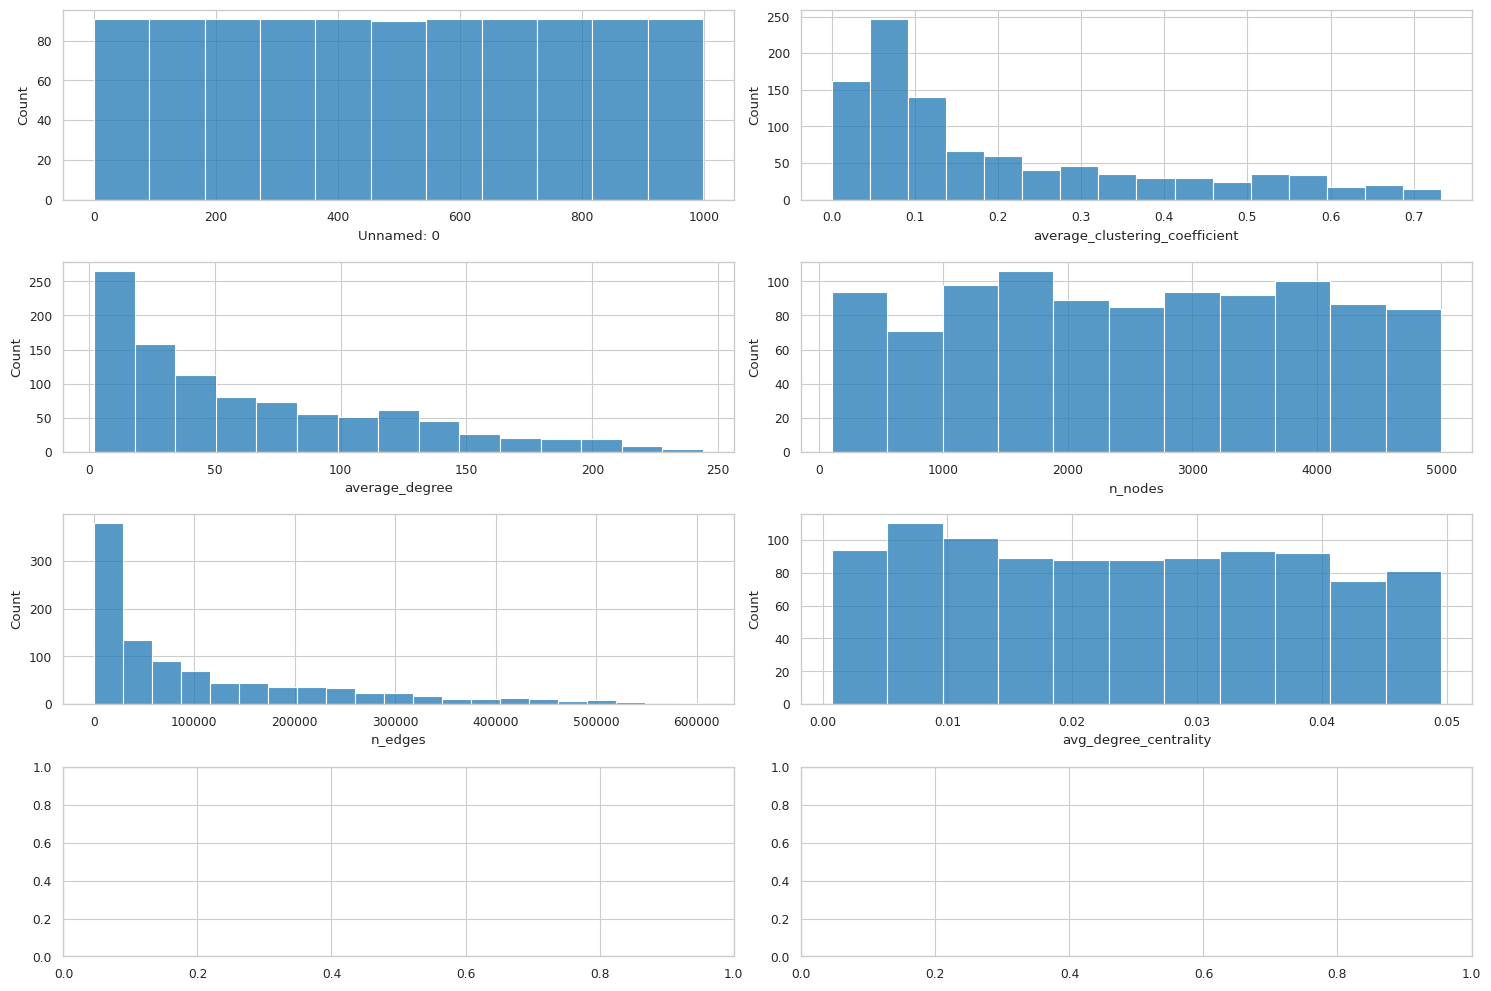

In [2]:
# plot a histogram for each metric
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_metrics = pd.read_csv("metrics.csv")

sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(4, 2, figsize=(15, 10))
print(df_metrics.columns)
for i, metric in enumerate(df_metrics.columns):
    print([i//2, i%2])
    if metric == "diameter" or metric == "average_shortest_path_length":
    # calculate the interval that contains 95% of the data
        interval = (df_metrics[metric].quantile(0.025), df_metrics[metric].quantile(0.95))
        print(interval)
        filtered_df = df_metrics[df_metrics[metric].between(*interval)]
        sns.histplot(data=filtered_df, x=metric, ax=ax[i//2, i%2])
    else:
        sns.histplot(data=df_metrics, x=metric, ax=ax[i//2, i%2])

plt.tight_layout()
plt.show()

In [19]:
data_files = [Path("data/validation/airports/raw/0.pt"),
             Path("data/validation/facebook/raw/0.pt"), 
             Path("data/validation/karate/raw/0.pt"),
             Path("data/validation/actor/raw/0.pt"),
             Path("data/validation/github/raw/0.pt"),
             Path("data/validation/wiki/raw/0.pt"),
             Path("data/validation/synthetic/raw/0.pt")
            ]
name = ["airports", "facebook", "karate", "actor", "github", "wiki", "synthetic"]

# create a list of dictionaries to store the data
metrics = []
settings = []

for data_file in tqdm(data_files):
    try:
        data = torch.load(data_file)
        metrics.append(data.metrics)
        settings.append(data.settings)
        metrics[-1]["name"] = name[data_files.index(data_file)]
    except:
        print(f"missing data file: {data_file}")
df_metrics = pd.DataFrame(metrics)
df_settings = pd.DataFrame(settings)
df_metrics.to_csv("metrics_validation.csv")
df_settings.to_csv("settings_validation.csv")

100%|██████████| 7/7 [00:00<00:00, 856.30it/s]

missing data file: data/validation/github/raw/0.pt
missing data file: data/validation/wiki/raw/0.pt


In [20]:
df_metrics

,diameter,average_shortest_path_length,average_clustering_coefficient,average_degree,n_nodes,n_edges,name
0,5,2.323611,0.539272,30.040100,399,5993,airports
1,8,3.692507,0.605547,43.691013,4039,88234,facebook
2,5,2.408200,0.570638,4.588235,34,78,karate
3,12,4.110280,0.080193,7.015526,7600,26659,actor
4,8,5.052639,0.299902,8.000000,3680,14720,synthetic


Index(['Unnamed: 0', 'diameter', 'average_shortest_path_length',
       'average_clustering_coefficient', 'average_degree', 'n_nodes',
       'n_edges'],
      dtype='object')


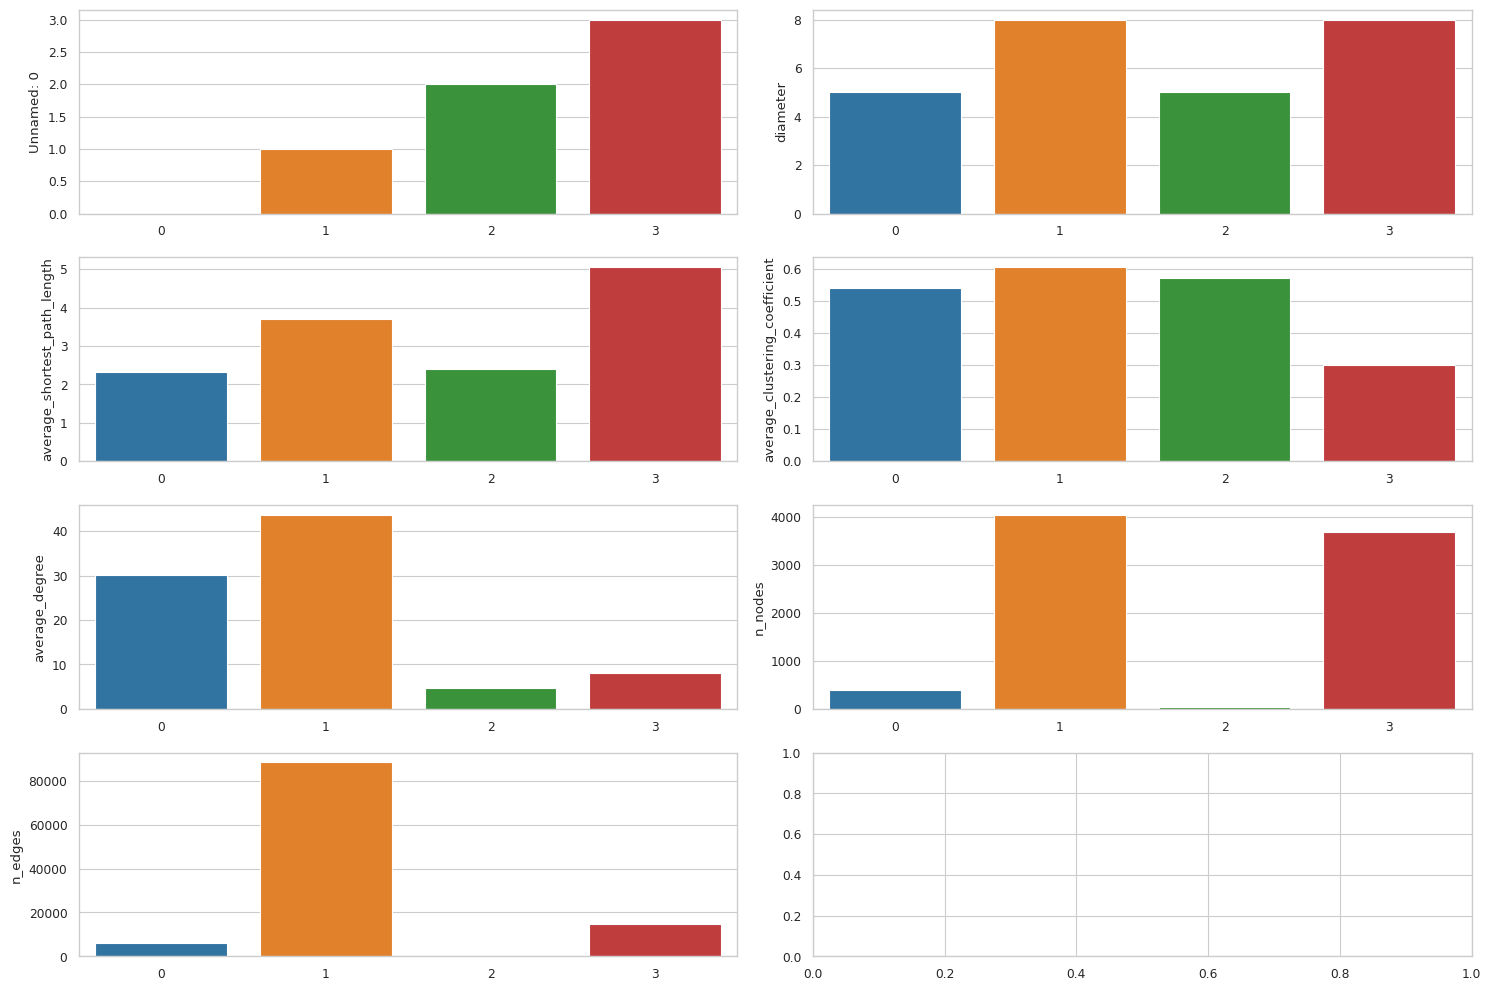

In [15]:
# plot a histogram for each metric
import matplotlib.pyplot as plt
import seaborn as sns

df_metrics = pd.read_csv("metrics_validation.csv")

sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(4, 2, figsize=(15, 10))
print(df_metrics.columns)
for i, metric in enumerate(df_metrics.columns):
    # distplay the metric using a bar plot
    sns.barplot(y=df_metrics[metric], x=df_metrics.index, ax=ax[i//2, i%2])

plt.tight_layout()
plt.show()